<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/regression_2Class_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import from drive

In [ ]:
import pandas as pd
import shutil
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv (r'/content/drive/My Drive/data - 2 class Regress.csv')
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico),Class_01
0,1,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom1,0-800,135.06,10,0
1,2,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom2,0-800,135.06,10,0
2,3,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom3,0-800,135.06,10,0
3,4,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom4,0-800,135.06,10,0
4,5,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/new train/pore-sb/PCC(...,zoom5,0-800,135.06,10,0
...,...,...,...,...,...,...,...,...,...,...
795,796,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom21,0-800,301.70,10,0
796,797,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom22,0-800,301.70,10,0
797,798,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom23,0-800,301.70,10,0
798,799,1-s2.0-S2095268622000210-main,"Integration of preparation of K, Na-embedded a...","Dingzheng Wang,Deqing Zhu,Jian Pan, Zhengqi Gu...",/content/drive/My Drive/new train/1-s2.0-S2095...,zoom24,0-800,301.70,10,0


## hist check class

In [ ]:
import matplotlib.pyplot as plt

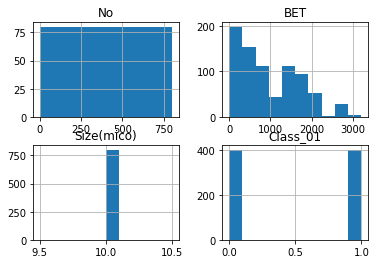

In [ ]:
df.hist();

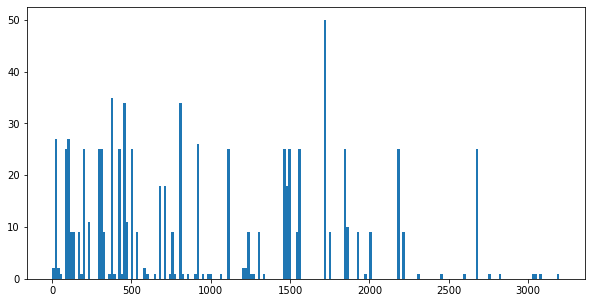

In [ ]:
a = df['BET']

fig, ax = plt.subplots(figsize =(10, 5))
ax.hist(a, bins = 200)
plt.show()

In [ ]:
classes = ['0-800','801-3200']
len(classes)

2

# การเเบ่งข้อมูล train/validation/test sets

In [ ]:
# base_dir = '/content/drive/My Drive/new Regress'
# os.makedirs(base_dir, exist_ok=True)

# # Directories for our training,
# # validation and test splits
# train_dir = os.path.join(base_dir, 'train')
# os.makedirs(train_dir, exist_ok=True)
# validation_dir = os.path.join(base_dir, 'validation')
# os.makedirs(validation_dir, exist_ok=True)
# test_dir = os.path.join(base_dir, 'test')
# os.makedirs(test_dir, exist_ok=True)

In [ ]:
val = df[df['No'].between(599,699)]
train = df[df['No'].between(1,598)]
test = df[df['No'].between(700,800)] 

# #Path Train
# T1_train = train[train['Class']=='0-800']
# T1_path_train = T1_train['path_Picture'].tolist() 
# T2_train = train[train['Class']=='801-3200']
# T2_path_train = T2_train['path_Picture'].tolist() 


# #Path Validation
# T1_val = val[val['Class']=='0-800']
# T1_path_val = T1_val['path_Picture'].tolist() 
# T2_val = val[val['Class']=='801-3200']
# T2_path_val = T2_val['path_Picture'].tolist() 



# #Path Test
# T1_test = test[test['Class']=='0-800']
# T1_path_test = T1_test['path_Picture'].tolist() 
# T2_test = test[test['Class']=='801-3200']
# T2_path_test = T2_test['path_Picture'].tolist() 


In [ ]:

DATA_PATH = '/content/drive/My Drive/new Regress'
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

/content/drive/My Drive/new Regress/train
/content/drive/My Drive/new Regress/validation


### Train

In [ ]:
# fnames = T1_path_train
# for fname in fnames:
#     dst = os.path.join(train_1_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# fnames = T2_path_train
# for fname in fnames:
#     dst = os.path.join(train_2_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
    


### Test

In [ ]:
# fnames = T1_path_test
# for fname in fnames:
#     dst = os.path.join(validation_1_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# fnames = T2_path_test
# for fname in fnames:
#     dst = os.path.join(validation_2_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)
    


###Validation

In [ ]:
# fnames = T1_path_val
# for fname in fnames:
#     dst = os.path.join(test_1_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)

# fnames = T2_path_val
# for fname in fnames:
#     dst = os.path.join(test_2_dir, os.path.basename(fname))
#     shutil.copyfile(fname, dst)


In [ ]:

# print('total training 1 images:', len(os.listdir(train_1_dir))) 
# print('total training 2 images:', len(os.listdir(train_2_dir)),'\n')

# print('total validation 1 images:', len(os.listdir(validation_1_dir)))
# print('total validation 2 images:', len(os.listdir(validation_2_dir)),'\n')

# print('total test 1 images:', len(os.listdir(test_1_dir)))
# print('total test 2 images:', len(os.listdir(test_2_dir)),'\n')


# Imports library

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

## hyper parameter


In [ ]:
batch_size = 16

width = 150
height = 150

epochs = 500 #จำนวนรอบในการ Train

NUM_TRAIN = 598  # จำนวนภาพ Train
NUM_TEST = 101 #จำนวนภาพ Test

dropout_rate = 0.3
input_shape = (height, width, 3) #ขนาด image enter

## Clone efficientnet repo

In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


## Import efficientnet and load the conv base model

In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [ ]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
#EfficientNet สร้างขึ้นสำหรับการจำแนกประเภท ImageNet ประกอบด้วยป้ายกำกับคลาส 1,000 รายการ เรามีเพียง 2 เลเยอร์เท่านั้น ซึ่งหมายความว่าเลเยอร์สองสามเลเยอร์สุดท้ายสำหรับการจำแนกไม่มีประโยชน์สำหรับเรา สามารถยกเว้นได้ขณะโหลดโมเดลโดยระบุอาร์กิวเมนต์ include_top เป็น False และนำไปใช้กับโมเดล ImageNet อื่นๆ ที่มีอยู่ในแอปพลิเคชัน Keras เช่นกัน

conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

# Show architecture model

In [ ]:
#ดัดแปลง GlobalMaxPooling2D เพื่อแปลง 4D the (batch_size, rows, cols,channels) tensor เป็น 2D tensor with shape (batch_size,channels)
#GlobalMaxPooling2D ส่งผลให้มีจำนวนฟีเจอร์น้อยกว่ามากเมื่อเทียบกับเลเยอร์ Flatten ซึ่งช่วยลดจำนวนพารามิเตอร์ได้อย่างมีประสิทธิภาพ

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(2, activation='softmax', name="fc_out"))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 2)                 2562      
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 4,052,129
Trainable params: 4,010,113
Non-trainable params: 42,016
_________________________________________

In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 215
This is the number of trainable layers after freezing the conv base: 4


# unfreeze

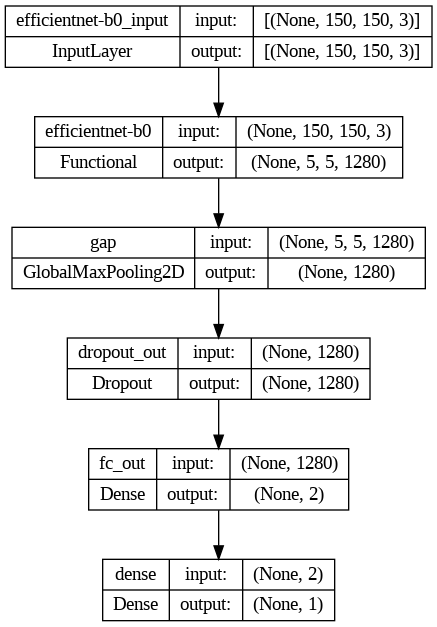

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='conv_base.png', show_shapes=True)

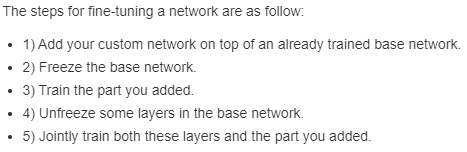

In [ ]:
from IPython.display import Image
Image(filename='/content/unfreeze.png')

In [ ]:
# set 'multiply_16' and following layers trainable (Unfreeze --> multiply_16 ) ให้เป็น layers ที่ train ชุดข้อมูลใหม่
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_15':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers after freezing the conv base: 10


## Setting data augmentation

In [ ]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
#Image Augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, # image input 0-255 --> 0-1 เปลี่ยนค่าสี
      rotation_range=40,# หมุนภาพในองศา
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ทำให้ภาพเบี้ยว
      zoom_range=0.2, # Randomly zoom image
      horizontal_flip=True, 
      #โดย Default เมื่อมีการเลื่อนภาพ บิดภาพ หมุนภาพ จะเกิดพื้นที่ว่างที่มุม 
      #ซึ่งจะมีการเติมภาพให้เต็มโดยใช้เทคนิคแบบ Nearest neighbor ซึ่งเป็นการดึงสีบริเวณใหล้าเคียงมาระบายให้เต็ม แต่เราก็ยังสามารถกำหนดวิธีการ Fill ภาพด้วยเทคนิคอื่นได้จาก Parameter fill_mode
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'path_Picture',
        y_col = 'Class_01',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = validation_dir,
        x_col = 'path_Picture',
        y_col = 'Class_01',
        class_mode = 'other',
        target_size=(height, width),
        batch_size=batch_size)

Found 598 validated image filenames.
Found 101 validated image filenames.


# Training

In [ ]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['mae'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/500


<ipython-input-54-d73197abddf2>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


37/37 [==============================] - 12s 141ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2499 - val_mae: 0.4999
Epoch 2/500
37/37 [==============================] - 3s 81ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2499 - val_mae: 0.4999
Epoch 3/500
37/37 [==============================] - 9s 220ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2500 - val_mae: 0.5000
Epoch 4/500
37/37 [==============================] - 5s 125ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 5/500
37/37 [==============================] - 5s 124ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2501 - val_mae: 0.5001
Epoch 6/500
37/37 [==============================] - 9s 228ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2500 - val_mae: 0.5000
Epoch 7/500
37/37 [==============================] - 5s 115ms/step - loss: 0.2500 - mae: 0.5000 - val_loss: 0.2500 - val_mae: 0.5000
Epoch 8/500
37/37 [==============================] - 8s 215ms/step - loss: 0.2500

In [ ]:
history.history 

{'loss': [0.2500166893005371,
  0.24999526143074036,
  0.25000062584877014,
  0.24997936189174652,
  0.2500341534614563,
  0.2500412166118622,
  0.24999882280826569,
  0.2499864250421524,
  0.2500579357147217,
  0.2500298321247101,
  0.25001418590545654,
  0.24996250867843628,
  0.2500362694263458,
  0.2500289976596832,
  0.24999520182609558,
  0.2500273883342743,
  0.24997356534004211,
  0.24999095499515533,
  0.24997693300247192,
  0.2500360310077667,
  0.25000953674316406,
  0.24994969367980957,
  0.25002816319465637,
  0.2500121593475342,
  0.2499886453151703,
  0.25003331899642944,
  0.25000426173210144,
  0.2499665915966034,
  0.2500375807285309,
  0.2500123083591461,
  0.25004762411117554,
  0.24998342990875244,
  0.249972864985466,
  0.24998214840888977,
  0.24998854100704193,
  0.24991676211357117,
  0.24998198449611664,
  0.2500401437282562,
  0.2500499188899994,
  0.24999669194221497,
  0.24995902180671692,
  0.2500143051147461,
  0.2499949336051941,
  0.2500322163105011,
  

### Plot training performance

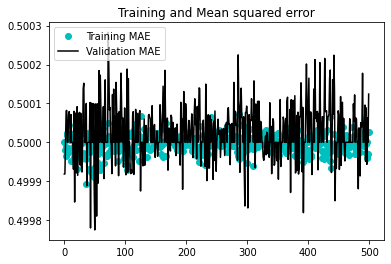

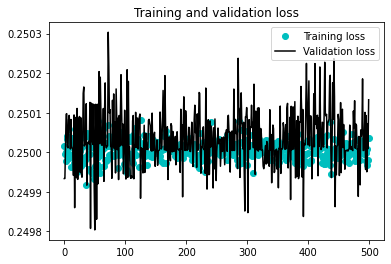

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mse = history.history['mae']
val_mse = history.history['val_mae']

epochs_x = range(len(loss))

plt.plot(epochs_x, mse, 'co', label='Training MAE')
plt.plot(epochs_x, val_mse, 'k', label='Validation MAE')
plt.title('Training and Mean squared error')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'co', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**SAVE model** 

In [ ]:
os.makedirs('./content/drive/My Drive/new', exist_ok=True)
model.save('./content/drive/My Drive/new/2Class_regression_500.h5')

In [ ]:
from google.colab import files

In [ ]:
files.download("./content/drive/My Drive/new/2Class_regression_500.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>